# Generative AI project

*by Fabian Fiedler, Alexander Roucka, Florian Kibler*

This project aims at the synthetic generation of new Pokemon (GANkemon). The network used is a Progressive Generative Adversarial Network.

The data used for training has been obtained from the following sources:

- [Pokemon - Image dataset](https://huggingface.co/datasets/huggan/pokemon) or [Alternative Link](https://www.kaggle.com/datasets/djilax/pkmn-image-dataset)

- [The Complete Pokemon Images Data Set](https://www.kaggle.com/datasets/arenagrenade/the-complete-pokemon-images-data-set)

- [Pokemon Images Dataset](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset)

- [7,000 Labeled Pokemon](https://www.kaggle.com/datasets/lantian773030/pokemonclassification)

- [Pokemon Generation One](https://www.kaggle.com/datasets/thedagger/pokemon-generation-one)

## Dependencies and config

In [15]:
import os
import torch
import json

from types import SimpleNamespace

from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset

from math import log2
import matplotlib.pyplot as plt

from model.Discriminator import Discriminator, DiscriminatorWrapper
from model.Generator import Generator
from model.train import train
from utils.set_seeds import set_seeds

from functions.example_generator import generate_example_animation, generate_examples
from utils.plot_images import plot_images
from utils.load_images_from_folder import load_images_from_folder
from utils.get_device import get_device

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

Set config for the experiments and network architecture.

In [2]:
config = {
    "experiment_name"         : "test_gradcam",
    "dataset"                 : "2D_assets", #2D_assets, all_assets, bulbapedia or all_assets_and_bulbapedia ###needs to have a subfolder(s) which contains the data
    "start_train_at_img_size" : 4,
    "device"                  : get_device(),
    "learning_rate"           : 1e-3,
    "batch_sizes"             : [32, 32, 32, 16, 16, 16, 8], # [8224, 4112, 1028, 256, 64, 32, 16] # you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
    "image_size"              : 128,
    "channels_img"            : 3,
    "z_dim"                   : 256,
    "in_channels"             : 256,
    "lambda_gp"               : 10,
    "epochs"                  : 100, #for continue these are the complete epochs incuding the already trained ones, for fine_tunining these are the extra epochs
    "save_every_n_epochs"     : 10,

    "load_model"              : True,
    "saved_path"              : "outputs/test_1_2D_assets_128x128/",
    "image_size_saved"        : 128,
    "last_epoch"              : 0, # use the one saved in the file
    "fine_tune"               : True,
    "pre_epochs_offset"       : 50,
    "seed"                    : 42
}

config = SimpleNamespace(**config)

config.progressive_epochs = [config.epochs] * len(config.batch_sizes)

#safety to disable pre_epochs_offset if fine_tune is False
if not config.fine_tune:
    config.pre_epochs_offset = 0

In [3]:
set_seeds(config.seed)
torch.backends.cudnn.benchmarks = True

Create experiment.

In [7]:
amount_folders = len([name for name in os.listdir("outputs") if os.path.isdir(os.path.join("outputs", name))])

config.experiment_name = f"{amount_folders}_{config.experiment_name}_{amount_folders}_{config.dataset}_{config.image_size}x{config.image_size}_e{config.epochs}"
print(config.experiment_name)

OUTPUT_DIR = f"outputs/{config.experiment_name}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

1_test_gradcam_1_2D_assets_128x128_e100


Store config.

In [9]:
json.dump(config.__dict__, open(f"{OUTPUT_DIR}/config.json", "w"))

## Dataset

In [4]:
def get_loader(image_size):
    """
    Get loader and pre-transform data.
    """
    batch_size = config.batch_sizes[int(log2(image_size / 4))]
    dataset = dset.ImageFolder(root=f"dataset/{config.dataset}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    return dataloader, dataset

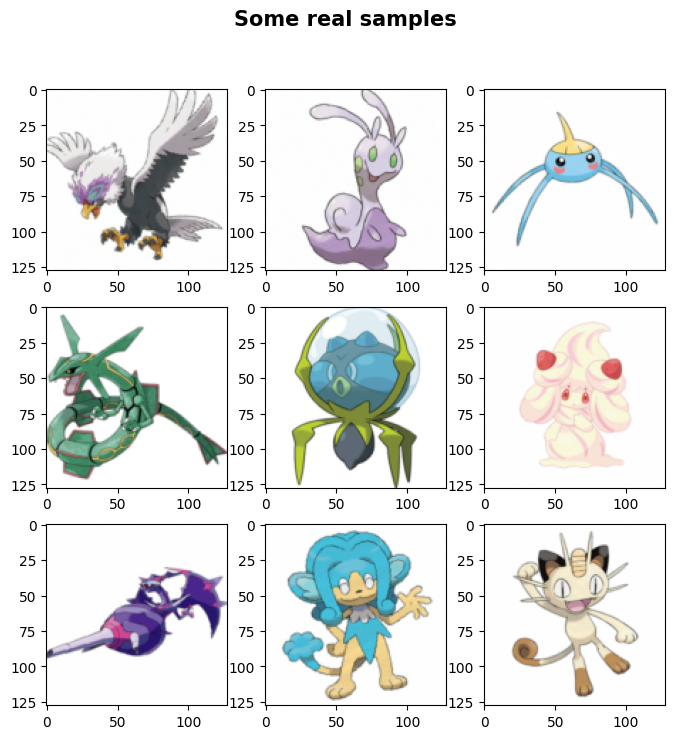

In [5]:
loader,_ = get_loader(128)
cloth ,_ = next(iter(loader))
_, ax    = plt.subplots(3,3, figsize=(8,8))
plt.suptitle("Some real samples", fontsize=15, fontweight="bold")
ind = 0 
for k in range(3):
    for kk in range(3):
        ind += 1
        ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 

In [8]:
def generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=None):
    """
    Generate samples and save models.
    """
    generate_examples(gen, step, config.z_dim, device=config.device, n=n, path=path, epoch=epoch)

    generator_name = f"{path}/generator_{4 * 2 ** step}"
    if epoch is not None:
        generator_name += f"_{epoch}"
    critic_name = f"{path}/critic_{4 * 2 ** step}"
    if epoch is not None:
        critic_name += f"_{epoch}"

    torch.save(gen.state_dict(), f"{generator_name}.pth")
    torch.save(critic.state_dict(), f"{critic_name}.pth")

## Training

Initialize generator and critic (discriminator).

In [11]:
gen = Generator(
    config.z_dim, config.in_channels, img_channels=config.channels_img
).to(config.device)

critic = Discriminator(
    config.in_channels, img_channels=config.channels_img
).to(config.device)

Load model if configured.

In [12]:
if config.load_model:
    saved_model_id = f"{config.image_size_saved}"
    config.start_train_at_img_size = config.image_size_saved*2
    if config.last_epoch != 0:
        saved_model_id += f"_{config.last_epoch}"
    if config.last_epoch != 0 or config.fine_tune:
        config.start_train_at_img_size = config.image_size_saved
    gen.load_state_dict(torch.load(config.saved_path + f"generator_{saved_model_id}.pth"))
    critic.load_state_dict(torch.load(config.saved_path + f"critic_{saved_model_id}.pth"))

Define optimizers. ADAM is used here for both the generator and the critic.

In [15]:
opt_gen = optim.Adam(gen.parameters(), lr=config.learning_rate, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.learning_rate, betas=(0.0, 0.99)
)

Train the model.

Current image size: 128
Epoch [1/100]


  0%|          | 0/413 [00:00<?, ?it/s]

  2%|▏         | 8/413 [00:12<10:53,  1.61s/it, gp=0.0141, loss_critic=-8.57]


Training interrupted by user
Model state saved successfully on interruption.
[]


IndexError: list index out of range

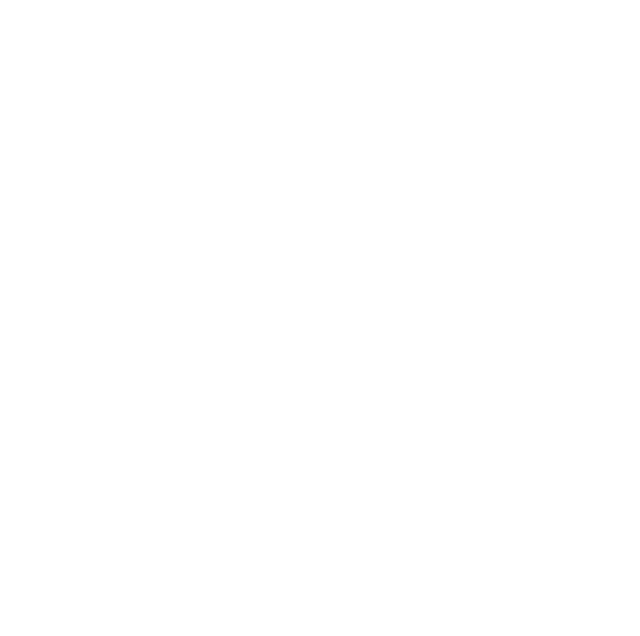

In [16]:
gen.train()
critic.train()

os.makedirs(OUTPUT_DIR, exist_ok=True)

step = int(log2(config.start_train_at_img_size / 4))
try:
    for num_epochs in config.progressive_epochs[step:]: #reduce iteration based on start image size (required if model loaded from drive)
        alpha = 1e-5
        loader, dataset = get_loader(4 * 2 ** step) # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        epochs_range = range(num_epochs)
        if config.load_model and config.last_epoch != 0:
            epochs_range = range(config.last_epoch, num_epochs)
        for epoch in epochs_range:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            alpha = train(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                config.z_dim,
                config.lambda_gp,
                config.progressive_epochs,
                config.device
            )
            if (epoch+1) % config.save_every_n_epochs == 0 and epoch != num_epochs-1:
                generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=epoch+1+config.pre_epochs_offset)
        
        epochs_naming = None
        if config.pre_epochs_offset:
            epochs_naming = epoch + 1 + config.pre_epochs_offset
        generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=epochs_naming)

        step += 1  # Progress to the next image size
        
except KeyboardInterrupt:
    print("Training interrupted by user")
    interupted_folder = f"{OUTPUT_DIR}/interrupted"
    os.makedirs(interupted_folder, exist_ok=True)
    torch.save(gen.state_dict(), f"{interupted_folder}/generator_interrupted_{4 * 2 ** step}.pth")
    torch.save(critic.state_dict(), f"{interupted_folder}/critic_interrupted{4 * 2 ** step}.pth")
    print("Model state saved successfully on interruption.")
finally:
    os.makedirs(f"{OUTPUT_DIR}/interrupted", exist_ok=True)
    generate_examples(gen, step, config.z_dim, device=config.device, n=100, path=f"{OUTPUT_DIR}/interrupted")
    generate_example_animation(OUTPUT_DIR   , 256, 256, 3, fps=3, display_animation=True)
    print("Cleaning up resources...")

Load and plot images for all steps.

In [ ]:
for step in range(0, 5):
    folder_path = rf"outputs/{config.experiment_name}/step{step}"
    images = load_images_from_folder(folder_path)
    print(f"Loaded {len(images)} images from {folder_path}")
    plot_images(images)

# Evaluation

Evaluation has been performed with Grad CAM which has been applied to the Discriminator of the ProGAN.

In [16]:
def visualize_grad_cam(cam, image_tensor, target_category=None):
    """ 
    Generates Grad-CAM visualization for the given image tensor. 
    viridis = most important areas are yellow, less important areas are blue
    """
    image_tensor = image_tensor.unsqueeze(0)
    grayscale_cam = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(target_category)])
    cam_image = show_cam_on_image(image_tensor.cpu().numpy()[0].transpose(1, 2, 0), grayscale_cam[0], use_rgb=True)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor.cpu().numpy()[0].transpose(1, 2, 0))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image, cmap="viridis")
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

Load Discriminator.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


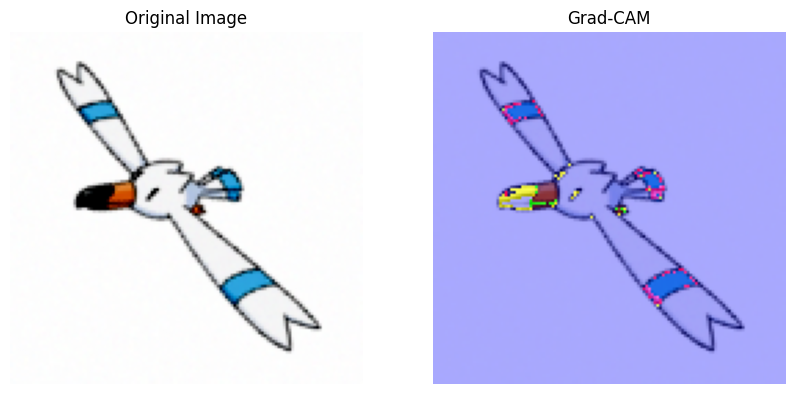

In [14]:
# Initialize loader and dataset
step = int(log2(config.start_train_at_img_size / 4))
loader, dataset = get_loader(4 * 2 ** step)

# Initialize the model
critic = Discriminator(
    config.in_channels, img_channels=config.channels_img
).to(config.device)
critic.load_state_dict(torch.load(config.saved_path + f"critic_{saved_model_id}.pth"))
critic.eval()

# Wrap the critic model
critic_wrapper = DiscriminatorWrapper(critic)

# Setup Grad-CAM using the wrapper
target_layers = [critic_wrapper.model.final_block[2]]  # Select the second-to-last convolutional layer
cam = GradCAM(model=critic_wrapper, target_layers=target_layers)

real_images = next(iter(loader))[0].to(config.device)

visualize_grad_cam(cam, real_images[0], target_category=1)